# Forecasting and Econometrics

- seasonality, spectral density, unit root, stationarity
- autocorrelation functions, AR, MA, SARIMAX
- scipy, statsmodels, seaborn, St Louis Fed FRED

Terence Lim

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns 
from finds.alfred import Alfred

from settings import settings
imgdir = os.path.join(settings['images'], 'ts')
alf = Alfred(api_key=settings['fred']['api_key'])

## Seasonality
- Real GDP Not Seasonally Adjusted

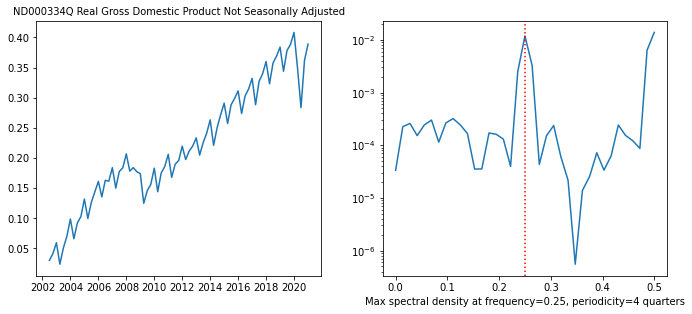

In [2]:
import scipy.signal
series_id = 'ND000334Q'  # real gdp
df = alf(series_id, log=1, diff=1, freq='Q').dropna()
x = df.values.flatten()  #y.iloc[:-240].copy()
fig, axes = plt.subplots(1, 2, num=1, clear=True, figsize=(10,5))
axes[0].plot(pd.DatetimeIndex(df.index.astype(str), freq='infer'),
             x.cumsum(), marker=None)
axes[0].set_title(" ".join(alf.header(
    series_id, ['id', 'title', 'seasonal_adjustment']).to_list()), fontsize=10)
    
freq, power = scipy.signal.welch(x - x.mean(), nperseg=4*(len(x)//4))
axes[1].semilogy(freq, power)
argmax = np.argmax(power[:-1])
axes[1].set_xlabel(f"Max spectral density at frequency={freq[argmax]:.2f}, "
                   f"periodicity={1/freq[argmax]:.0f} quarters",fontsize=10)
axes[1].axvline(freq[argmax], ls=':', c='r')
plt.tight_layout(pad=3)
plt.savefig(os.path.join(imgdir, 'welch.jpg'))
plt.show()

## Stationarity and Unit Root 
## helper test methods

In [3]:
from statsmodels.tsa.stattools import adfuller
def unit_root(x, pvalue=0.05, noprint=False):
    """test if input series has unit root using augmented dickey fuller"""
    dftest = adfuller(x, autolag='AIC')
    if not noprint:
        results = Series(dftest[0:4],
                         index=['Test Statistic','p-value', 'Lags Used',
                                'Obs Used'])
        for k,v in dftest[4].items():
            results[f"Critical Value ({k})"] = v
        print(results.to_frame().T.to_string(index=False))
    return dftest[1] > pvalue

def integration_order(df, noprint=True, max_order=5, pvalue=0.05):
    """returns order of integration by iteratively testing for unit root"""
    for i in range(max_order):
        if not noprint:
            print(f"Augmented Dickey-Fuller unit root test of I({i}):")
        if not unit_root(df, pvalue=pvalue, noprint=noprint):
            return i
        df = df.diff().dropna()

## Integration Order: Real GDP (Seasonally Adjusted)

In [4]:
    s = 'GDPC1'
    df = alf(s, log=1, freq='Q')
    df.index = pd.DatetimeIndex(df.index.astype(str))
    p = integration_order(df, noprint=False, pvalue=0.05)
    Series({s: p}, name='I(p)').to_frame()

Augmented Dickey-Fuller unit root test of I(0):
 Test Statistic  p-value  Lags Used  Obs Used  Critical Value (1%)  Critical Value (5%)  Critical Value (10%)
      -2.689601 0.075855        0.0     295.0            -3.452713            -2.871388             -2.572017
Augmented Dickey-Fuller unit root test of I(1):
 Test Statistic      p-value  Lags Used  Obs Used  Critical Value (1%)  Critical Value (5%)  Critical Value (10%)
      -15.20593 5.742859e-28        0.0     294.0             -3.45279            -2.871422             -2.572035


,I(p)
GDPC1,1


## Histogram Plot and Kernel Density Estimate

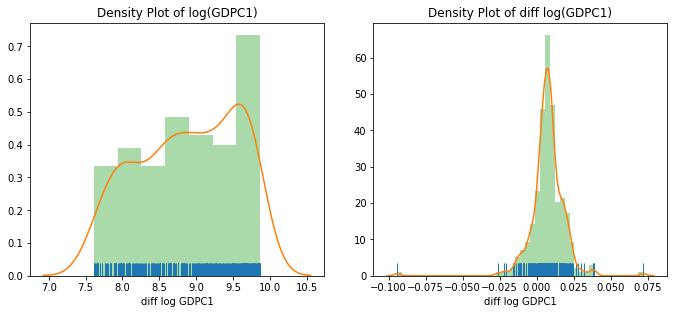

In [5]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, num=1, clear=True, figsize=(10,5))
sns.distplot(df.dropna().rename(f"diff log {s}"), hist=True, kde=True,
             rug=True, ax=axes[0], rug_kws={"color": "C0"},
             kde_kws={"color": "C1"}, hist_kws={"color": "C2"})
axes[0].set_title(f"Density Plot of log({s})")
sns.distplot(df.diff().dropna().rename(f"diff log {s}"), hist=True, kde=True,
             rug=True, ax=axes[1], rug_kws={"color": "C0"},
             kde_kws={"color": "C1"}, hist_kws={"color": "C2"})
axes[1].set_title(f"Density Plot of diff log({s})")
plt.savefig(os.path.join(imgdir, 'order.jpg'))
plt.tight_layout(pad=3)
plt.show()

# Autocorrelation Function
## Plot ACF and PACF

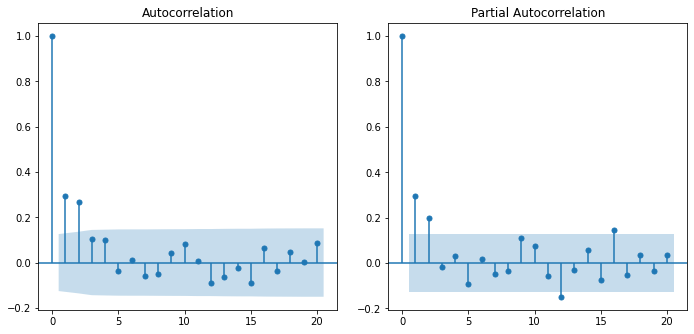

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = alf('GDPC1', start=19590101, end=20191231, log=1, diff=1, freq='Q')[1:]
df.index = pd.DatetimeIndex(df.index.astype(str), freq='infer')
fig, axes = plt.subplots(1, 2, clear=True, figsize=(10,5))
#df.plot(ax=axes[0], title="$\Delta$ log(GDPC1)")
plot_acf(df.values.squeeze(), lags=20, ax=axes[0])
plot_pacf(df, lags=20, ax=axes[1])
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'acf.jpg'))
plt.show()

## Select AR Lag Order
Split train period is 2017 and before, test period is after 2017.  Ignore 2020.

In [7]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
s = 'GDPC1'  # real gdp, seasonally adjusted
df = alf(s, log=1, diff=1, start=19591201, freq='Q').loc[:20191231].dropna()
df.index = pd.DatetimeIndex(df.index.astype(str), freq='infer')
df_train = df[df.index <= '2017-12-31']
df_test = df[df.index > '2017-12-31']
lags = ar_select_order(df_train, maxlag=13, ic='bic',old_names=False).ar_lags
print('(BIC) lags= ', len(lags), ':', lags)

(BIC) lags=  2 : [1 2]


## AR and SARIMAX
AR(p) is simplest time-model.

Nested in SARIMAX(p,d,q,s) which can include moving average MA(q), integration order I(d), seasonality S(s), exogenous X

Also: Vector Autoregression, and State-Space Models

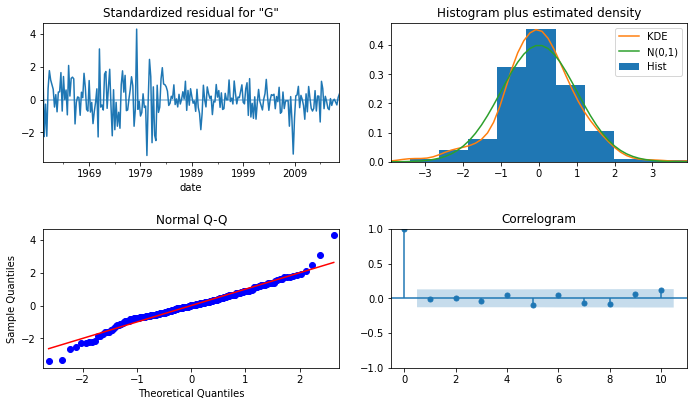

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  GDPC1   No. Observations:                  233
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 800.139
Date:                Tue, 09 Mar 2021   AIC                          -1592.279
Time:                        17:06:16   BIC                          -1578.492
Sample:                    12-31-1959   HQIC                         -1586.718
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.001      6.440      0.000       0.003       0.005
ar.L1          0.2606      0.057      4.560      0.000       0.149       0.373
ar.L2          0.1970      0.056      3.545      0.000       0.088       0.306
sigma2      5.901e-05   3.86e-06     15.304      0.000    5.15e-05    6.66e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                42.48
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
adf = alf(s, log=1, freq='Q').loc[19591201:20171231]
adf.index = pd.DatetimeIndex(adf.index.astype(str), freq='infer')
arima = SARIMAX(adf, order=(2, 1, 0), trend='c').fit()
fig = arima.plot_diagnostics(figsize=(10,6))
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'ar.jpg'))
plt.show()
arima.summary()

## Forecasting
producing OOS forecasts requires two models. The first must exclude the OOS 
period. The second uses the predict method from the full-sample model with the 
parameters from the shorter sample model that excluded the OOS period.  Three different methods of predictions:
- One-Period Ahead Predictions
- Multi-Period Prediction
- Recursive One-Period Predictions

In [11]:
model = AutoReg(df_train, lags=lags, old_names=False).fit()  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  GDPC1   No. Observations:                  232
Model:                     AutoReg(2)   Log Likelihood                 796.500
Method:               Conditional MLE   S.D. of innovations              0.008
Date:                Tue, 09 Mar 2021   AIC                             -9.729
Time:                        17:07:16   BIC                             -9.669
Sample:                    09-30-1960   HQIC                            -9.705
                         - 12-31-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      5.448      0.000       0.003       0.006
GDPC1.L1       0.2606      0.064      4.078      0.000       0.135       0.386
GDPC1.L2       0.1970      0.063      3.105      0.002       0.073       0.321
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6866           +0.0000j            1.6866            0.0000
AR.2           -3.0094           +0.0000j            3.0094            0.5000
-----------------------------------------------------------------------------
"""

## One-period ahead prediction: observations to predict are from the test split

Short-term Forecasts:  rmse=0.002312 r2=0.0704


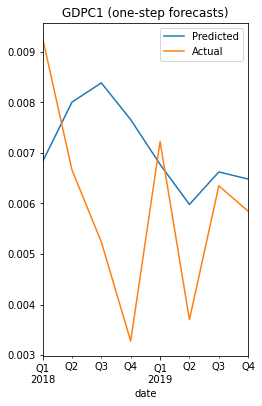

In [13]:
from sklearn.metrics import mean_squared_error        
all_dates = AutoReg(df, lags=lags, old_names=False)
df_pred = all_dates.predict(model.params,
                            start=df_train.index[-1]).shift(1).iloc[1:]
mse = mean_squared_error(df_test, df_pred)
var = np.mean(np.square(df_test - df_train.mean()))
print(f"Short-term Forecasts:  rmse={np.sqrt(mse):.6f} r2={1-mse/var:.4f}")
fig, ax = plt.subplots(clear=True, num=1, figsize=(4,6))
df_pred.plot(ax=ax, c='C0')
df_test.plot(ax=ax, c='C1')
ax.legend(['Predicted', 'Actual'])
ax.set_title(s + " (one-step forecasts)")
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'short.jpg'))
plt.show()

## Multi-period ahead prediction

Long-term Forecasts:  rmse=0.002425 r2=-0.0226


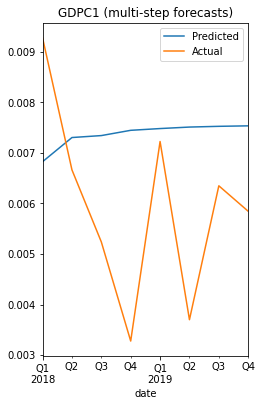

In [14]:
df_pred = all_dates.predict(model.params,
                            start=df_train.index[-1],
                            end=df_test.index[-1],
                            dynamic=0).shift(1).iloc[1:]
mse = mean_squared_error(df_test, df_pred)
var = np.mean(np.square(df_test - df_train.mean()))
print(f"Long-term Forecasts:  rmse={np.sqrt(mse):.6f} r2={1-mse/var:.4f}")
fig, ax = plt.subplots(clear=True, num=2, figsize=(4,6))
df_pred.plot(ax=ax, c='C0')
df_test.plot(ax=ax, c='C1')
ax.legend(['Predicted', 'Actual'])
ax.set_title(s + " (multi-step forecasts)")
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'long.jpg'))
plt.show()

## One-step ahead expanding re-estimation window predictions

Expanding Forecasts:  rmse=0.002305 r2=0.0759


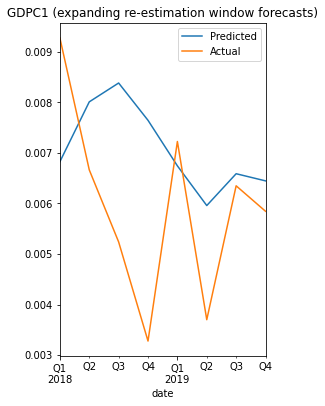

In [15]:
df_pred = DataFrame(index=df_test.index)
for date in df_pred.index:
    expand = AutoReg(df[df.index < date], lags=lags, old_names=False).fit()
    df_pred.loc[date, 'pred'] = float(expand.predict(start=-1, end=-1))
mse = mean_squared_error(df_test, df_pred)
var = np.mean(np.square(df_test - df_train.mean()))
print(f"Expanding Forecasts:  rmse={np.sqrt(mse):.6f} r2={1-mse/var:.4f}")
fig, ax = plt.subplots(clear=True, num=3, figsize=(4,6))
df_pred.plot(ax=ax, c='C0')
df_test.plot(ax=ax, c='C1')
ax.legend(['Predicted', 'Actual'])
ax.set_title(s + " (expanding re-estimation window forecasts)")
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'recursive.jpg'))
plt.show()